In [440]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [441]:
# Loading the datasets
#HPI = pd.read_csv("USSTHPI.csv") # Quarterly HPI data
HPI_PO = pd.read_csv("HPI_Purchase_only_yoy_change.csv") # HPI Purchase Only data
EHS = pd.read_excel("Existing Home Sales.xlsx") # Existing Home Sales data, Chris supplied
StockQt = pd.read_excel("HousingStockWorksheet.xlsx", sheet_name = "Stock_Quarterly") # Housing Stock data, Chris supplied

In [442]:
# Just chaging the column name and cleaning the data
HPI_PO.DATE = pd.to_datetime(HPI_PO.DATE)
new_name = {'HPIPONM226S_PC1' : "YoY"}
HPI_PO.rename(columns=new_name, inplace= True)
HPI_PO.drop(HPI_PO.tail(1).index, inplace= True)
HPI_PO.YoY = HPI_PO.YoY.astype(float)

In [443]:
StockQt.rename(columns={"Unnamed: 15" : "col 15", "Unnamed: 16" : "Eff_HS_US"}, inplace=True)
StockQt.drop(columns=["col 15"], inplace= True)
StockQt.dropna(subset=["Eff_HS_US"],inplace = True)
Quarters = StockQt.Quarter.values
Quarter_to_Date = {"Q1" : "-01-01",
                  "Q2" : "-04-01",
                  "Q3" : "-07-01",
                  "Q4" : "-10-01"}
Dates = []
for i in Quarters:
    y = i.split()[0]
    y+= Quarter_to_Date[i.split()[1]]
    Dates.append(y)
StockQt.Quarter = Dates


In [444]:
EHS.EOM = pd.to_datetime(EHS.EOM)
EHS.rename(columns= {"EOM" : "DATE"}, inplace = True)
EHS.dropna(subset=["Existing Home Sales"], inplace=True)

In [445]:
EHS["DATE"] = EHS.DATE.dt.to_period('Q')
EHS_Q = pd.DataFrame(EHS.groupby("DATE").mean())
EHS_Q.reset_index(inplace= True)
EHS_Q.drop(EHS_Q.tail(1).index,inplace=True)

In [446]:
EHS_Q["House_Stock"] = StockQt.Eff_HS_US.values

In [447]:
EHS_Q

,DATE,Existing Home Sales,House_Stock
0,1999Q1,5.160000,79655.0
1,1999Q2,5.233333,80146.0
2,1999Q3,5.200000,80656.0
3,1999Q4,5.093333,80094.0
4,2000Q1,5.180000,80776.0
...,...,...,...
88,2021Q1,6.286667,94048.0
89,2021Q2,5.950000,94117.0
90,2021Q3,6.066667,94192.0
91,2021Q4,6.203333,94865.0


In [448]:
EHS_Q["Implied_Turnover"] = (EHS_Q["Existing Home Sales"]/(EHS_Q.House_Stock/1000))*100

In [449]:
Turnover = list(EHS_Q.Implied_Turnover.values)
Turnover = [np.nan]*(HPI_PO.shape[0]-len(Turnover))+Turnover
HPI_PO["Implied_Turnover"] = Turnover
HPI_PO["YoY_MA"] = HPI_PO.YoY.rolling(5).mean()

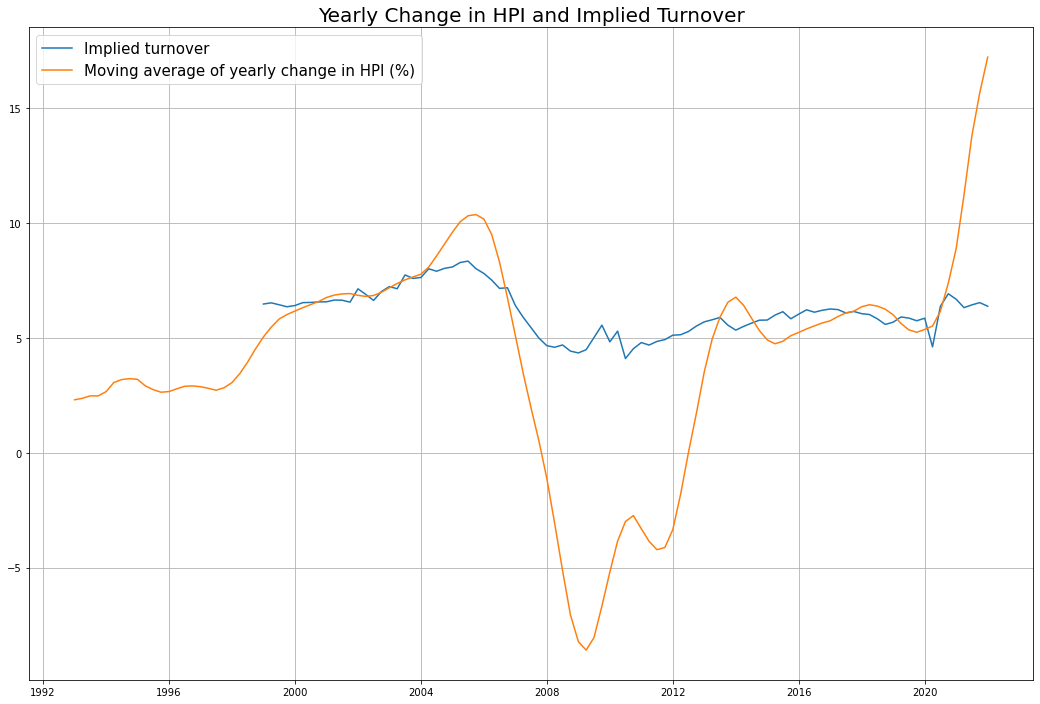

In [450]:
plt.figure(figsize=(18,12))
#plt.plot(HPI_PO.DATE, HPI_PO.YoY.values, label = "Yearly change in HPI (%)")
plt.plot(HPI_PO.DATE, HPI_PO.Implied_Turnover.values, label = "Implied turnover")
plt.plot(HPI_PO.DATE, HPI_PO.YoY_MA, label = "Moving average of yearly change in HPI (%)")
plt.legend(fontsize = 15)
plt.grid()
plt.title("Yearly Change in HPI and Implied Turnover", size = 20);


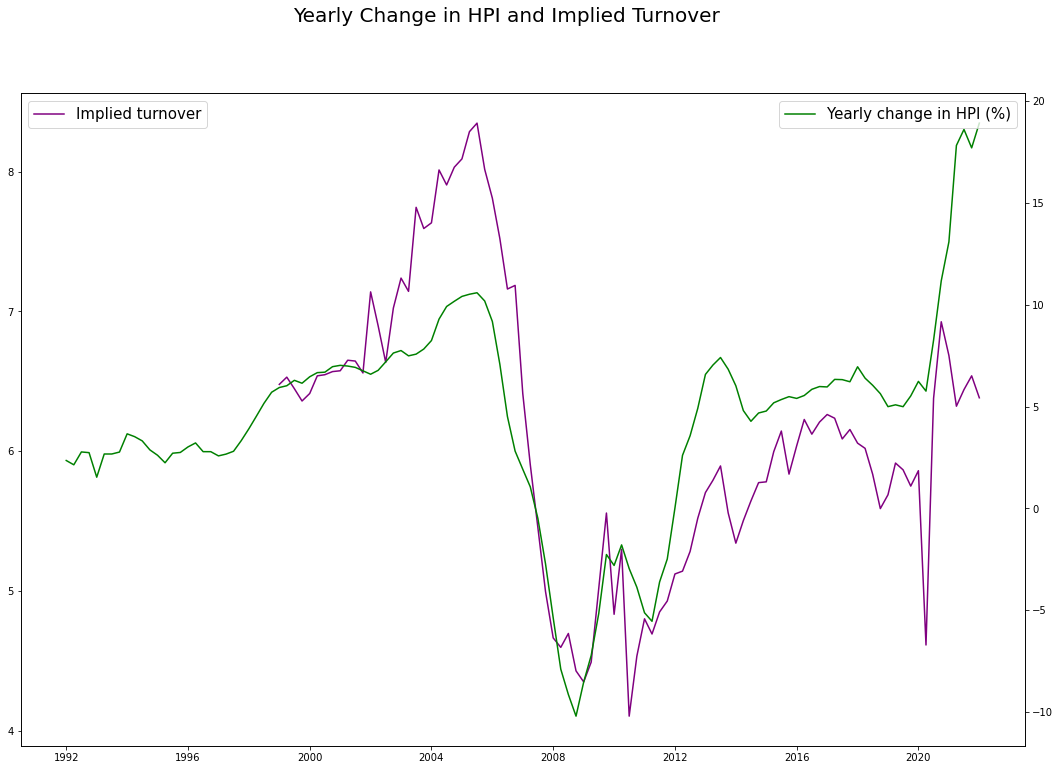

In [780]:
fig,ax1 = plt.subplots()
fig.set_figheight(12)
fig.set_figwidth(18)
ax1.plot(HPI_PO.DATE, HPI_PO.Implied_Turnover, linewidth=1.5,label='Implied turnover', color = 'purple')
ax2 = ax1.twinx()
ax2.plot(HPI_PO.DATE, HPI_PO.YoY, linewidth=1.5,color='green',label='Yearly change in HPI (%)')
ax1.legend(loc='upper left', fontsize=15)
ax2.legend(loc='upper right', fontsize=15)
fig.suptitle("Yearly Change in HPI and Implied Turnover", size = 20)
plt.show()
fig.savefig("HPIvsIT.png")

In [753]:
HCAI = pd.read_excel("HCAI.xlsx", sheet_name="Whole Market")
HCAI
new_header = HCAI.loc[2]
HCAI = HCAI[3:]
HCAI.columns = new_header
HCAI = HCAI[HCAI.columns[:6]]
HCAI.rename(columns={"Year" : "DATE"}, inplace=True)

In [754]:
HCAI.DATE = HCAI.DATE.apply(lambda x: str(x).split()[0])
DATE = HCAI.DATE.values
Quarter = HCAI.Quarter.values
new_dates = []
for i in range(len(DATE)):
    if Quarter[i] == 1:
        new_dates.append(DATE[i]+"-01-01")
    elif Quarter[i] == 2:
        new_dates.append(DATE[i]+"-04-01")
    elif Quarter[i] == 3:
        new_dates.append(DATE[i]+"-07-01")
    elif Quarter[i] == 4:
        new_dates.append(DATE[i]+"-10-01")
    else:
        raise ValueError("Invalid value for quarter")
HCAI.DATE = new_dates
HCAI.DATE = pd.to_datetime(HCAI.DATE)
HCAI.columns = [x.replace("\n", '') for x in HCAI.columns.to_list()]
HCAI = HCAI.iloc[4:,[0,3]]

In [755]:
df = pd.merge(HPI_PO, HCAI, on='DATE', how='outer')
df.dropna(subset=["Implied_Turnover"], inplace = True)
df.fillna(method='ffill',inplace= True)
cols = ["DATE", "YoY", "TotalRisk", "Implied_Turnover"]
X = df[["YoY", "TotalRisk"]]
y = df.Implied_Turnover

In [756]:
X_YoY = pd.DataFrame(X.YoY)
X_TR = pd.DataFrame(X.TotalRisk)
YoY_lags = 12
TR_lags = 12
for lag in range(2,YoY_lags):
    s = "YoY_MA_Lag%i"%lag
    X_YoY[s] = X_YoY.YoY.rolling(lag).mean()
for lag in range(2,TR_lags):
    s = "TR_MA_Lag%i"%lag
    X_TR[s] = X_TR.TotalRisk.rolling(lag).mean()


In [757]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

ModelDescription ={}
for i in range(YoY_lags-1):
    data = pd.concat([X_YoY.iloc[:,i],y], axis = 1)
    data.dropna(inplace=True)
    X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:1], data.iloc[:,1], test_size=0.1, shuffle=False)
    model = LinearRegression()
    model_name = "model_YoY_%i"%i
    ModelDescription[model_name] = {"Features" : X_train.columns.to_list()}
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    ModelDescription[model_name]["model"] = model
    ModelDescription[model_name]["RMSE"] = np.sqrt(mean_squared_error(y_test, predictions))
    ModelDescription[model_name]["R^2"] = r2_score(y_test, predictions)
    lm = sm.OLS.from_formula("Implied_Turnover ~ %s"%data.columns.to_list()[-2], data=data).fit()
    ModelDescription[model_name]["lm"] = lm
    
    
    
    
for j in range(TR_lags-1):
    data = pd.concat([X_TR.iloc[:,j], y], axis=1)
    data.dropna(inplace=True)
    X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:1], data.iloc[:,1], test_size=0.1, shuffle=False)
    model = LinearRegression()
    model_name = "model_tr_%i"%j
    ModelDescription[model_name] = {"Features" : X_train.columns.to_list()}
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    ModelDescription[model_name]["model"] = model
    ModelDescription[model_name]["RMSE"] = np.sqrt(mean_squared_error(y_test, predictions))
    ModelDescription[model_name]["R^2"] = r2_score(y_test, predictions)
    lm = sm.OLS.from_formula("Implied_Turnover ~ %s"%data.columns.to_list()[-2], data=data).fit()
    ModelDescription[model_name]["lm"] = lm
    

In [758]:
rmses = []
R2s = []
for i in ModelDescription.values():
    #print(i["RMSE"],'  ', i["Features"])
    rmses.append(i["RMSE"])
    R2s.append(i["R^2"])

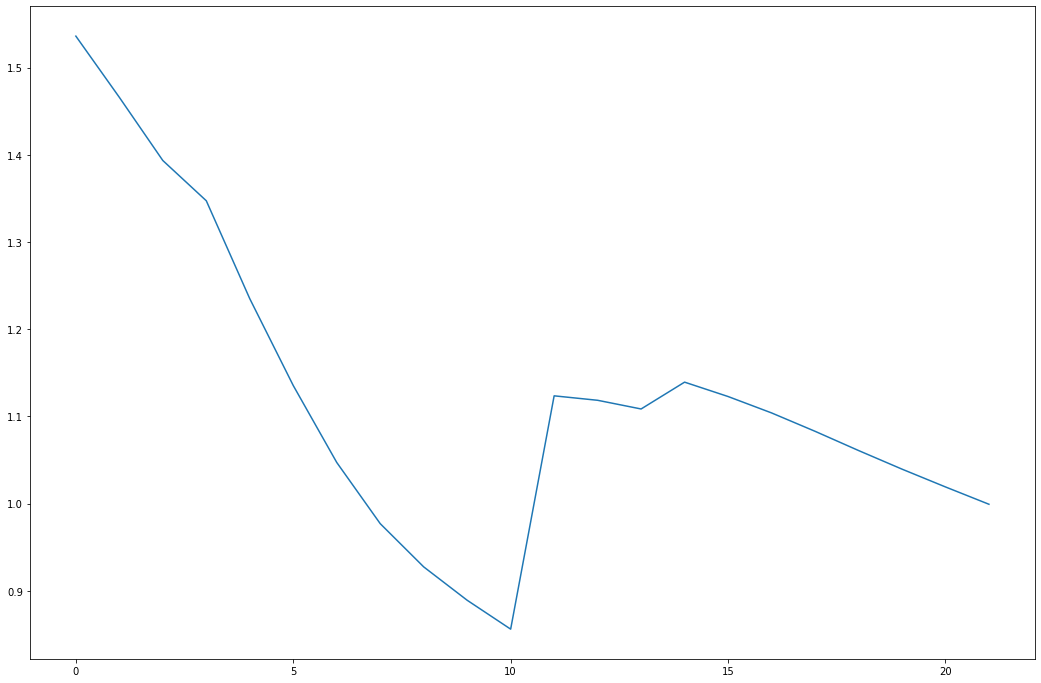

In [759]:
plt.figure(figsize=(18,12))
plt.plot(rmses)

In [760]:
for i in list(ModelDescription.values())[:50]:
    print(i["RMSE"],'  ', i["Features"])

1.536202204032949    ['YoY']
1.4660232045263062    ['YoY_MA_Lag2']
1.3935519634128128    ['YoY_MA_Lag3']
1.3473766385191266    ['YoY_MA_Lag4']
1.2350431713747962    ['YoY_MA_Lag5']
1.1354611112072432    ['YoY_MA_Lag6']
1.0472525840663438    ['YoY_MA_Lag7']
0.9770639256060255    ['YoY_MA_Lag8']
0.9274805801148291    ['YoY_MA_Lag9']
0.8891891282325367    ['YoY_MA_Lag10']
0.8560596683103961    ['YoY_MA_Lag11']
1.123653696384148    ['TotalRisk']
1.118544457748194    ['TR_MA_Lag2']
1.1085823480885402    ['TR_MA_Lag3']
1.1393521449202726    ['TR_MA_Lag4']
1.122868713132375    ['TR_MA_Lag5']
1.1040708538137247    ['TR_MA_Lag6']
1.0829952297647898    ['TR_MA_Lag7']
1.0609517250004656    ['TR_MA_Lag8']
1.0395891798426102    ['TR_MA_Lag9']
1.019169977608446    ['TR_MA_Lag10']
0.999296321220762    ['TR_MA_Lag11']


In [761]:
for i in (ModelDescription.values()):
    print(i["lm"].summary())

                            OLS Regression Results                            
Dep. Variable:       Implied_Turnover   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     100.8
Date:                Sat, 23 Jul 2022   Prob (F-statistic):           2.12e-16
Time:                        12:36:14   Log-Likelihood:                -97.191
No. Observations:                  93   AIC:                             198.4
Df Residuals:                      91   BIC:                             203.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.5309      0.094     58.866      0.0

[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
                            OLS Regression Results                            
Dep. Variable:       Implied_Turnover   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     29.83
Date:                Sat, 23 Jul 2022   Prob (F-statistic):           4.83e-07
Time:                        12:36:15   Log-Likelihood:                -110.78
No. Observations:                  85   AIC:                             225.6
Df Residuals:                      83   BIC:                             230.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [763]:
data = pd.concat([X_YoY.YoY_MA_Lag7, X_TR.TotalRisk,y], axis = 1)
data.isna().sum()

YoY_MA_Lag7         6
TotalRisk           0
Implied_Turnover    0
dtype: int64

In [777]:
lm = sm.OLS.from_formula("Implied_Turnover ~ TotalRisk+ YoY_MA_Lag7", data = data.iloc[:-10,:]).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Implied_Turnover   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     219.0
Date:                Sat, 23 Jul 2022   Prob (F-statistic):           8.32e-32
Time:                        14:00:28   Log-Likelihood:                -40.008
No. Observations:                  77   AIC:                             86.02
Df Residuals:                      74   BIC:                             93.05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.4210      0.123     36.004      0.000       4.176       4.666
TotalRisk       0.1334      0.014      9.400      0.000       0.105       0.162
YoY_MA_Lag7     0.1230      0.011     10.947      0.000       0.101       0.145
==============================================================================
Omnibus:                        0.253   Durbin-Watson:                   0.509
Prob(Omnibus):                  0.881   Jarque-Bera (JB):                0.304
Skew:                          -0.130   Prob(JB):                        0.859
Kurtosis:                       2.836   Cond. No.                         29.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [778]:
lm.predict(data.iloc[-10:,:2])

111    5.809903
112    5.805005
113    5.778163
114    5.804557
115    5.925312
116    6.071590
117    6.299474
118    6.532455
119    6.733782
120    6.964823
dtype: float64

In [779]:
data.Implied_Turnover[-10:]

111    5.750411
112    5.860617
113    4.613646
114    6.377489
115    6.925938
116    6.684530
117    6.321918
118    6.440745
119    6.539117
120    6.382089
Name: Implied_Turnover, dtype: float64

In [781]:
np.sqrt(mean_squared_error(lm.predict(data.iloc[-9:,:2]),data.Implied_Turnover[-9:]))

0.6192091095734293

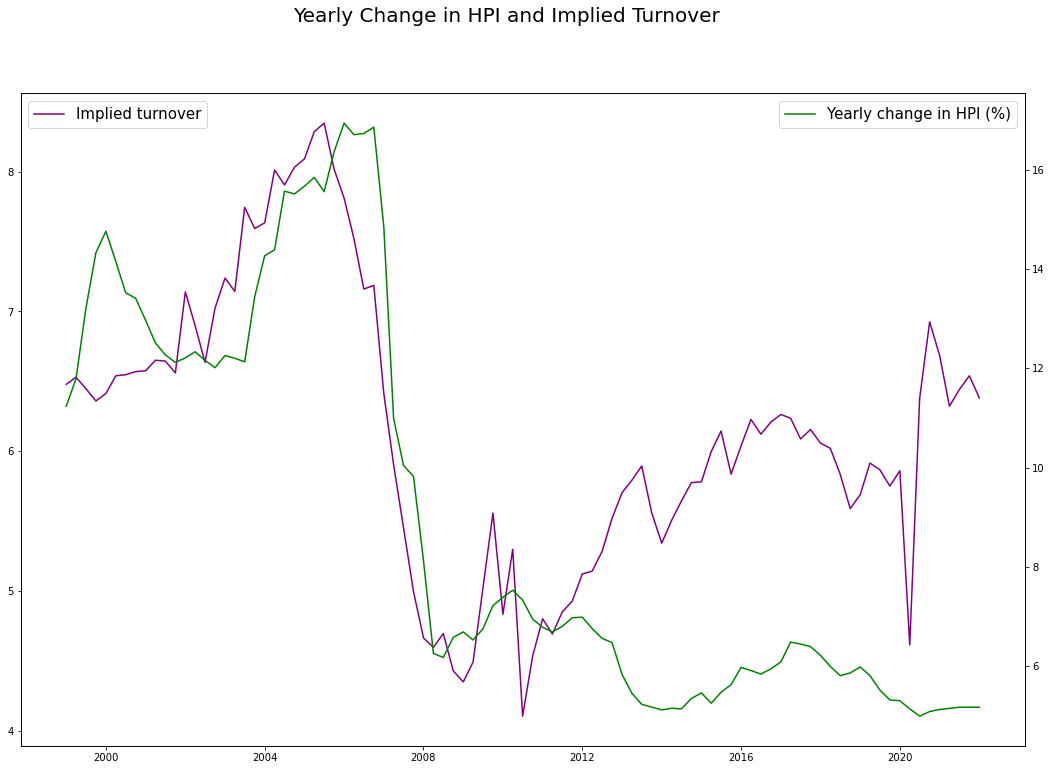

In [784]:
fig,ax1 = plt.subplots()
fig.set_figheight(12)
fig.set_figwidth(18)
ax1.plot(df.DATE, df.Implied_Turnover, linewidth=1.5,label='Implied turnover', color = 'purple')
ax2 = ax1.twinx()
ax2.plot(df.DATE,df.TotalRisk, linewidth=1.5,color='green',label='HCAI')
ax1.legend(loc='upper left', fontsize=15)
ax2.legend(loc='upper right', fontsize=15)
fig.suptitle("Yearly Change in HPI and Implied Turnover", size = 20)
plt.show()
fig.savefig("HCAIvsIT.png")

In [783]:
df

,DATE,YoY,Implied_Turnover,YoY_MA,TotalRisk
28,1999-01-01,5.93694,6.477936,5.049380,11.235860
29,1999-04-01,6.02527,6.529750,5.471682,11.789989
30,1999-07-01,6.29097,6.447134,5.824094,13.208564
31,1999-10-01,6.14804,6.359195,6.021422,14.332389
32,2000-01-01,6.46462,6.412796,6.173168,14.764346
...,...,...,...,...,...
116,2021-01-01,13.08681,6.684530,8.903530,5.124921
117,2021-04-01,17.81826,6.321918,11.219404,5.144927
118,2021-07-01,18.60512,6.440745,13.788192,5.169036
119,2021-10-01,17.70045,6.539117,15.676364,5.169036
